<center> <h1>Evidence on returns to active strategies</h1> </center>

<center>William Mann</center>

<center>
<img src="https://wgjm1986.github.io/Investments/Emory_small.png" height="200px" width="300px" />
</center>                                                                                            

## Backtesting an investment strategy

Suppose you are considering whether to pursue an active strategy. (Remember, this means any strategy other than "value-weight all available investments," which can also be called "holding the market portfolio".)

"Backtesting" means checking how well you would have done in the past by following that strategy. A natural idea is to compare this past performance with the performance of a passive strategy .

Of course, you really want to know how the strategy will do in the *future*, not the past. There is not necessarily any connection between the two. Nevertheless, most people will ask for some kind of historical evidence that a strategy works before investing in it.

Backtesting can be a surprisingly tricky thing to do correctly. We will lay out a few concepts today, and build on them as the semester progresses.

## Backtesting concept: Build large portfolios

Most investment ideas can be summarized in terms of some feature or characteristic that makes a stock attractive.
To backtest such an idea, you would like to abstract away from individual stocks or companies, and think more about the characteristic itself.

This means we will typically form large, diversified portfolios of stocks that score well on a given characteristics, and large portfolios of stocks that do not score so well.

We will track the performance of the "good" and "bad" portfolios over many historical years in order to get an idea of how they perform on average relative to each other.

## Backtesting concept: Prevent lookahead bias

A basic question about the stock market is: Do small-cap stocks or large-cap stocks have higher returns on average?

Suppose you look up the 500 smallest-cap and largest-cap stocks, as of December 2023, and compare their average returns over the prior 5 years. 
- What will you find?
- What is the problem with this analysis?

In [273]:
import wrds
import pandas as pd
from matplotlib import pyplot as plt

conn = wrds.Connection(wrds_username='wmann')
monthly_stocks = conn.raw_sql("""
SELECT 
    m.permno,
    m.date, 
    n.ticker, 
    m.prc,
    m.ret,
    m.shrout
FROM 
    crsp.msf AS m
JOIN 
    crsp.msenames AS n
ON 
    m.permno = n.permno
AND 
    m.date BETWEEN n.namedt AND n.nameendt
WHERE 
    m.date BETWEEN '1930-01-01' AND '2023-12-31'
AND
    n.shrcd in (10,11)
ORDER BY 
    m.date, n.ticker;
    """, date_cols=['date'])
conn.close()

monthly_stocks = monthly_stocks.dropna(subset=['ret', 'prc'])
monthly_stocks['prc'] = monthly_stocks['prc'].abs()

monthly_stocks['mkt_cap'] = monthly_stocks['prc'] * monthly_stocks['shrout']

monthly_stocks['date'] = pd.to_datetime(monthly_stocks['date'])
monthly_stocks['year'] = monthly_stocks['date'].dt.year
monthly_stocks['month'] = monthly_stocks['date'].dt.month

Loading library list...
Done


### Biggest 10 stocks by market cap, Dec 2023

In [286]:
monthly_stocks[(monthly_stocks['year']==2023) & (monthly_stocks['month']==12)].drop_duplicates('ticker',keep='first').nlargest(10,'mkt_cap')[['ticker','mkt_cap']]

,ticker,mkt_cap
288805,AAPL,2.994371e+09
291206,MSFT,2.794828e+09
289022,AMZN,1.570153e+09
291387,NVDA,1.223193e+09
290386,GOOGL,8.266854e+08
290385,GOOG,8.068242e+08
292427,TSLA,7.898983e+08
291091,META,7.856521e+08
290931,LLY,5.533700e+08
290763,JPM,4.917605e+08


In [ ]:
return_2023 = monthly_stocks[monthly_stocks['year'] >= 2019].groupby('permno')['ret'].mean().rename('ret_2023')

In [ ]:
Dec_2023_MC_returns = monthly_stocks[(monthly_stocks['year'] == 2023) & (monthly_stocks['month'] == 12)][['permno','ticker','mkt_cap']].set_index('permno').merge(
    return_2023,left_index=True,right_index=True)

Average monthly returns from 2019-2023, of the smallest and largest 500 stocks by market cap as of December 2023:

In [295]:
large_cap_avg_return = Dec_2023_MC_returns.nlargest(500,'mkt_cap')['ret_2023'].mean()
print(f"Largest 500: {100*large_cap_avg_return :.2f}%")
small_cap_avg_return = Dec_2023_MC_returns.nsmallest(500,'mkt_cap')['ret_2023'].mean()
print(f"Smallest 500: {100*small_cap_avg_return :.2f}%")

Largest 500: 1.76%
Smallest 500: -4.01%


Average returns from 2019-2023, of the smallest and largest 500 stocks by market cap as of **December 2018**:

In [ ]:
Dec_2018_MC_returns = monthly_stocks[(monthly_stocks['year'] == 2018) & (monthly_stocks['month'] == 12)][['permno','ticker','mkt_cap']].set_index('permno').merge(
    return_2023,left_index=True,right_index=True)

In [296]:
large_cap_avg_return = Dec_2018_MC_returns.nlargest(500,'mkt_cap')['ret_2023'].mean()
print(f"Largest 500: {100*large_cap_avg_return :.2f}%")
small_cap_avg_return = Dec_2018_MC_returns.nsmallest(500,'mkt_cap')['ret_2023'].mean()
print(f"Smallest 500: {100*small_cap_avg_return :.2f}%")

Largest 500: 1.53%
Smallest 500: 1.96%


- Large-cap stocks *as of December 2023* had higher returns during 2019-2023.
- Large-cap stocks *as of December 2018* had lower returns  2019-2023.
- Does it make sense why the conclusion reverses? 
- Which approach is a more correct backtest?

## Let's extend this analysis:

Suppose we go back every year to 1931:
- Each year we sort stocks into 10 deciles by market cap as of that year.
- We get the average return of stocks in each decile in that year. 
- Repeat for each year.
- We now have almost 100 years of data on returns to ten different "strategies" (deciles) that position us more or less aggressively towards large-cap or small-cap stocks.
- Take the average of the return on each decile from 1931 to the present, and compare these averages to inform us about how small-cap stocks perform compard to large-cap stocks.

## Continuing to illustrate lookahead bias:

To remind us of the example we just did, we will compare two approaches:
- In year t, sort stocks into deciles by their market cap **at the end of year t**, and calculate the average return of each decile during year t.
- In year t, sort stocks into deciles by their market cap **at the end of year t-1**, and calculate the average return of each decile during year t.  

What do we expect to see? Which approach is a more convincing backtest of the strategy?

In [290]:
%%capture

q = 10

returns = []
for year in range(1931,2023):
    returns_t = monthly_stocks[monthly_stocks['year'] == year].groupby('permno')['ret'].mean().rename('ret_year')
    mc_Dec = monthly_stocks[(monthly_stocks['year']==year) & (monthly_stocks['month']==12)][['permno','mkt_cap']]
    mc_Dec['decile']=pd.qcut(mc_Dec['mkt_cap'],q,labels=False,duplicates='drop')
    mc_Dec_returns = mc_Dec.set_index('permno').merge(returns_t,left_index=True,right_index=True)
    decile_returns = mc_Dec_returns.groupby('decile')['ret_year'].mean()
    returns.append(decile_returns)

decile_return_averages = [ pd.Series([decile_returns[decile] for decile_returns in returns ]).mean() for decile in range(0,q) ]

lookahead_fig,ax = plt.subplots()
ax.bar(range(1,q+1),decile_return_averages)
ax.set_xticks(range(1,q+1))
ax.set_xlabel(r"Decile of market cap, \textbf{this} December",usetex=True)
ax.set_ylabel("Average return of stocks in this decile, \n 1931-2023");

## Results from approach 1:

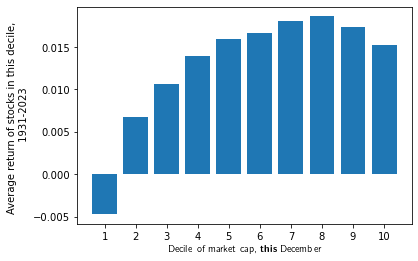

In [293]:
lookahead_fig

When we sort stocks by market capitalization from the end of the *current* year, we find that large-cap stocks exhibited higher returns during the year.

In [292]:
%%capture

q = 10

returns = []
for year in range(1931,2023):
    returns_t = monthly_stocks[monthly_stocks['year'] == year].groupby('permno')['ret'].mean().rename('ret_year')
    mc_Dec = monthly_stocks[(monthly_stocks['year']==year-1) & (monthly_stocks['month']==12)][['permno','mkt_cap']]
    mc_Dec['decile']=pd.qcut(mc_Dec['mkt_cap'],q,labels=False,duplicates='drop')
    mc_Dec_returns = mc_Dec.set_index('permno').merge(returns_t,left_index=True,right_index=True)
    decile_returns = mc_Dec_returns.groupby('decile')['ret_year'].mean()
    returns.append(decile_returns)

decile_return_averages = [ pd.Series([decile_returns[decile] for decile_returns in returns ]).mean() for decile in range(0,q) ]

correct_figure,ax = plt.subplots()
ax.bar(range(1,q+1),decile_return_averages)
ax.set_xticks(range(1,q+1))
ax.set_xlabel(r"Decile of market cap, \textbf{previous} December",usetex=True)
ax.set_ylabel("Average return of stocks in this decile, \n 1931-2020");

## Results from approach 2:

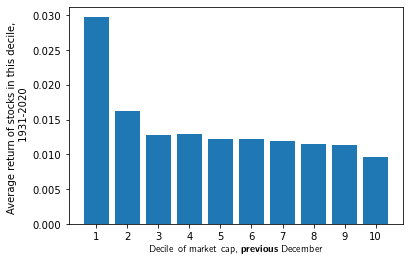

In [294]:
correct_figure

When we sort stocks by market capitalization at the end of the *prior* year, we find that it was *small-cap* stocks that exhibited higher returns.  

Why does this make sense? Why is this the correct approach?

### Backtesting concept: Value-weighted portfolios

If you look at the code up to this point, we're just taking simple averages of all stocks.

As we've seen, this corresponds with an equal-weighted strategy, which is actually quite active.

That adds a theme to our investment proposal that we don't really want.
For this reason it's slightly better to use value-weighted portfolios.

This is not universally done in practice, but is standard in academia, and we will mostly take this approach.

## Investment styles: Size, value, and momentum

A “style” is a simple characteristic of an investment,
that is used to form broad portfolios to (hopefully) beat the market.

In the stock market, the best-known styles are:
- Size: Another name for market capitalization.
- Value: A valuation ratio involving the stock price.
- Momentum: The stock’s return over recent months.

Today we will look at average returns based on these styles,
using evidence from the US stock market from 1926 to the present.

(Later in the course we will use “factor” as another name for “style”.)

## Backtesting a style-based investment strategy

1. Give a precise definition of the style you are studying. Examples:
    - **Size:** The market capitalization of the stock’s issuer.
    - **Value:** The issuer’s book-to-market ratio.
    - **Momentum:** The price increase from month t − 13 to t − 1.  

(Definitions vary in practice, but we will focus on those listed above.)

2. Backtest the performance of portfolios sorted on this basis:  
- At the start of each past year in your data, sort stocks into different portfolios based on the characteristic you are studying.
- Calculate each portfolio’s value-weighted return for that year.
- Repeat for each year in the data.

3. Compare each portfolio’s returns with the market.

At this point we will download standard data instead of trying to do it ourself!

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import wrds
import math
import numpy
import statsmodels.formula.api
import wget, shutil
import os

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [16.0, 8.0]

### Average returns across portfolios formed on market cap

Compare textbook figure 11.4. The years are 1926-2021.

In [2]:
%%capture

# Download Ken French's historical data on 10 portfolios formed on market capitalization ("size")
try: os.remove('Portfolios_Formed_on_ME_CSV.zip')
except OSError: pass
try: os.remove('Portfolios_Formed_on_ME.CSV')
except OSError: pass
wget.download('https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/Portfolios_Formed_on_ME_CSV.zip','Portfolios_Formed_on_ME_CSV.zip')
shutil.unpack_archive('Portfolios_Formed_on_ME_CSV.zip')

# Read the data from the CSV file
size_portfolios = pd.read_csv('Portfolios_Formed_on_ME.CSV',skiprows=2372,nrows=97)
size_portfolios.columns = ['year','negative','l030','med40','hi30','q1','q2','q3','q4','q5','d1','d2','d3','d4','d5','d6','d7','d8','d9','d10']
size_portfolios = size_portfolios[['year','d1','d2','d3','d4','d5','d6','d7','d8','d9','d10']].set_index('year')
size_portfolios = size_portfolios/100

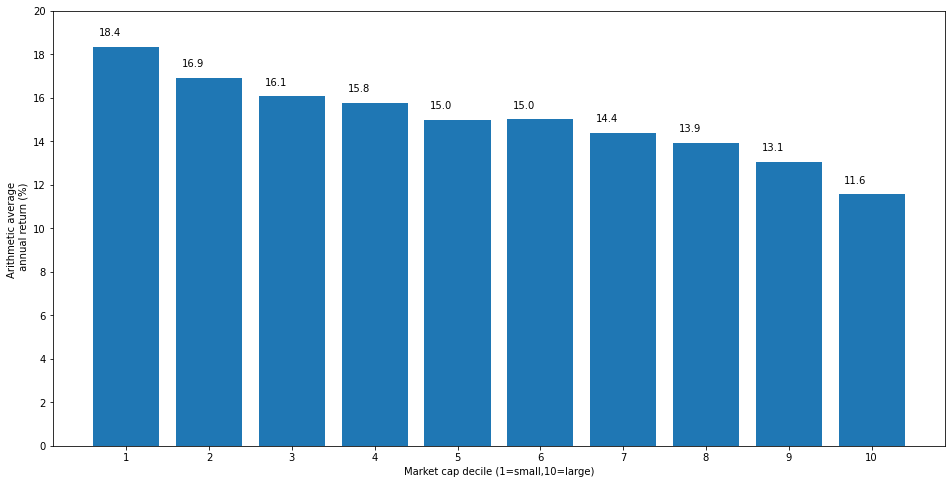

In [3]:
# Build the textbook's figure 11.4. (End in 2021 for consistency with that figure.)
size_portfolios = size_portfolios.loc['1926':'2021']
size_portfolios_figure = plt.figure();
means = [100*size_portfolios['d'+str(n)].mean() for n in range(1,11)];
plt.bar(range(1,11),means);
plt.xticks(range(1,11),range(1,11));
plt.yticks([2*i for i in range(0,11)]);
for i in range(1,11):
    plt.text(i-0.33,means[i-1]+0.5,"%3.1f" % means[i-1]);
plt.xlabel("Market cap decile (1=small,10=large)");
plt.ylabel("Arithmetic average \n annual return (%)");

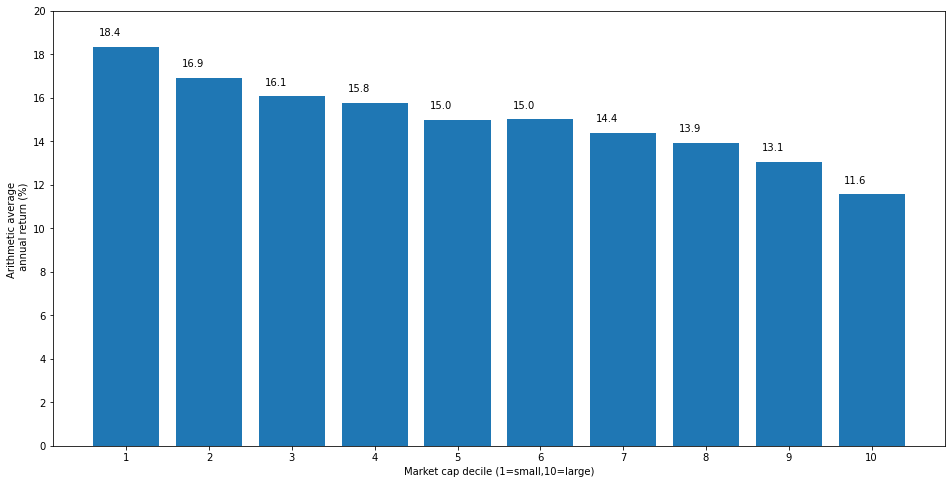

In [4]:
size_portfolios_figure

### Average returns across portfolios formed on book-to-market

Compare textbook figure 11.5. The years are 1926-2021.

In [5]:
%%capture

# Download Ken French's historical data on 10 portfolios formed on book-to-market ratio ("value")
try: os.remove('Portfolios_Formed_on_BE-ME_CSV.zip')
except OSError: pass
try: os.remove('Portfolios_Formed_on_BE-ME.CSV')
except OSError: pass
wget.download('https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/Portfolios_Formed_on_BE-ME_CSV.zip','Portfolios_Formed_on_BE-ME_CSV.zip')
shutil.unpack_archive('Portfolios_Formed_on_BE-ME_CSV.zip')

# Read the data from the CSV file and plot average annual returns across the portfolios, as we did for size above.
value_portfolios = pd.read_csv('Portfolios_Formed_on_BE-ME.CSV',skiprows=2383,nrows=97)
value_portfolios.columns = ['year','negative','l030','med40','hi30','q1','q2','q3','q4','q5','d1','d2','d3','d4','d5','d6','d7','d8','d9','d10']
value_portfolios = value_portfolios[['year','d1','d2','d3','d4','d5','d6','d7','d8','d9','d10']].set_index('year')
value_portfolios = value_portfolios/100

# Build the figure
value_portfolios = value_portfolios.loc['1926':'2021']
value_portfolios_figure = plt.figure()
means = [100*value_portfolios['d'+str(n)].mean() for n in range(1,11)]
plt.bar(range(1,11),means);
plt.xticks(range(1,11),range(1,11));
plt.yticks([2*i for i in range(0,11)]);
for i in range(1,11):
    plt.text(i-0.33,means[i-1]+0.5,"%3.1f" % means[i-1]);
plt.xlabel("B/M decile (1=low,10=high)")
plt.ylabel("Arithmetic average \n annual return (%)");

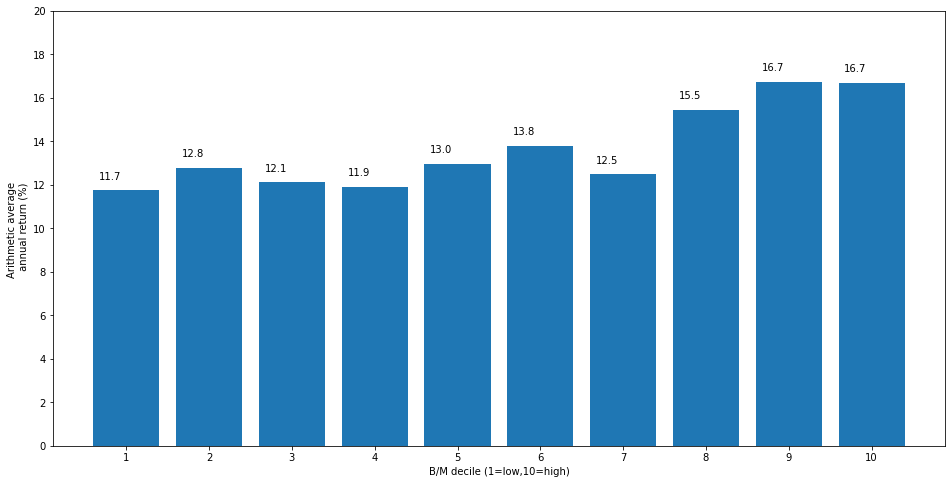

In [6]:
value_portfolios_figure

### Average returns across portfolios formed on momentum

In [7]:
%%capture

# Download Ken French's historical data on 10 portfolios formed on recent price increases ("momentum")
try: os.remove('10_Portfolios_Prior_12_2_CSV.zip')
except OSError: pass
try: os.remove('10_Portfolios_Prior_12_2.CSV')
except OSError: pass
wget.download('https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/10_Portfolios_Prior_12_2_CSV.zip','10_Portfolios_Prior_12_2_CSV.zip')
shutil.unpack_archive('10_Portfolios_Prior_12_2_CSV.zip')

# Read the data from the CSV file and plot average annual returns across the portfolios, as we did for size and value above.
mom_portfolios = pd.read_csv('10_Portfolios_Prior_12_2.CSV',skiprows=2358,nrows=97)
mom_portfolios.columns = ['year','d1','d2','d3','d4','d5','d6','d7','d8','d9','d10']
mom_portfolios = mom_portfolios.set_index('year')
mom_portfolios = mom_portfolios/100
mom_portfolios = mom_portfolios.loc['1926':'2021']

# Build the figure
momentum_portfolios_figure = plt.figure()
means = [100*mom_portfolios['d'+str(n)].mean() for n in range(1,11)]
plt.bar(range(1,11),means);
plt.xticks(range(1,11),range(1,11));
plt.yticks([2*i for i in range(0,11)]);
for i in range(1,11):
    plt.text(i-0.33,means[i-1]+0.5,"%3.1f" % means[i-1]);
plt.xlabel("Momentum decile (1=low,10=large)");
plt.ylabel("Arithmetic average \n annual return (%)");

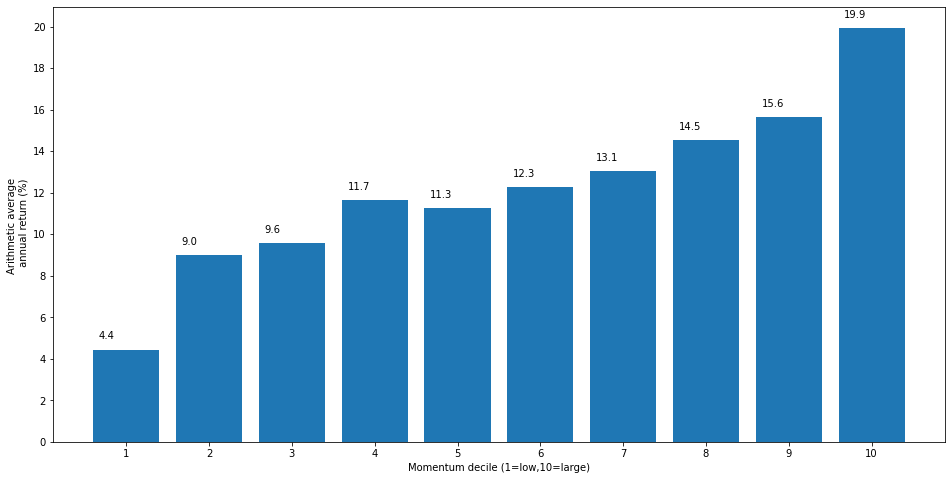

In [8]:
momentum_portfolios_figure

## What is missing from this evidence?

- Past performance does not guarantee future performance.
    - As we mentioned earlier, we can’t do much about this.

- Transaction costs may be quite large.
    - We will spend some time on this issue, but not much.
    - In general, it doesn’t change today’s conclusions: Style-based strategies have outperformed the market.

- **Risk**: We have only looked at long-run averages (90+ years).
    - For any one person, there is no guarantee what the average will be within their investment horizon, or what kind of short-term risk they might have to accept to pursue these strategies.
    - How should we measure risk? How much risk is too much? These questions are our main focus after Midterm 1.

## Comparison of average return and volatility across portfolios formed on size

In [11]:
%%capture
size_volatility_figure = plt.figure()
means = [100*size_portfolios['d'+str(n)].mean() for n in range(1,11)]
vols = [100*size_portfolios['d'+str(n)].std() for n in range(1,11)]
plt.scatter(vols,means);
for i in range(1,11):
    plt.text(vols[i-1]+0.1,means[i-1]-0.1,str(i));
plt.xlabel("Volatility of annual return");
plt.ylabel("Arithmetic average annual return");

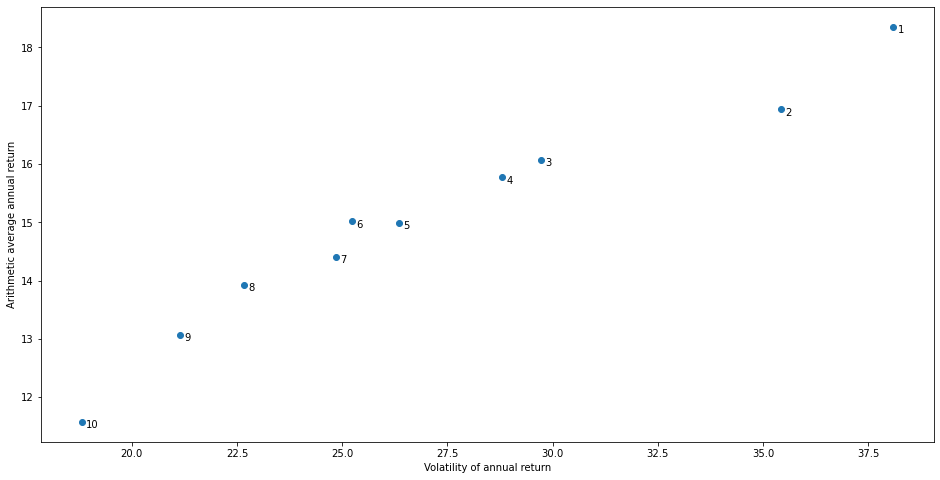

In [12]:
size_volatility_figure